In [1]:
#Dependencies 
import numpy as np
import pandas as pd
import requests
import time
import json
import datetime
#from us import states
from scipy.stats import linregress
import scipy.stats as st
from matplotlib import pyplot as plt
from glob import glob
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter


In [2]:
##### Covid data from CDC API starting here:
url = "https://data.cdc.gov/resource/vbim-akqf.json"
print(requests.get(url))
print(requests.get(url).json())

url = "https://data.cdc.gov/resource/vbim-akqf.json"
response = requests.get(url)
response_json = response.json()
print(json.dumps(response_json, indent=4, sort_keys=True))

<Response [200]>
[{'cdc_report_dt': '2020-07-03T00:00:00.000', 'current_status': 'Laboratory-confirmed case', 'sex': 'Female', 'age_group': '0 - 9 Years', 'race_ethnicity_combined': 'American Indian/Alaska Native, Non-Hispanic', 'hosp_yn': 'Missing', 'icu_yn': 'Missing', 'death_yn': 'Missing', 'medcond_yn': 'Missing'}, {'cdc_report_dt': '2020-05-27T00:00:00.000', 'current_status': 'Laboratory-confirmed case', 'sex': 'Female', 'age_group': '0 - 9 Years', 'race_ethnicity_combined': 'American Indian/Alaska Native, Non-Hispanic', 'hosp_yn': 'No', 'icu_yn': 'Missing', 'death_yn': 'No', 'medcond_yn': 'Missing'}, {'cdc_report_dt': '2020-06-06T00:00:00.000', 'current_status': 'Laboratory-confirmed case', 'sex': 'Female', 'age_group': '0 - 9 Years', 'race_ethnicity_combined': 'American Indian/Alaska Native, Non-Hispanic', 'hosp_yn': 'Missing', 'icu_yn': 'Missing', 'death_yn': 'Missing', 'medcond_yn': 'Missing'}, {'cdc_report_dt': '2020-06-28T00:00:00.000', 'current_status': 'Laboratory-confirme

[
    {
        "age_group": "0 - 9 Years",
        "cdc_report_dt": "2020-07-03T00:00:00.000",
        "current_status": "Laboratory-confirmed case",
        "death_yn": "Missing",
        "hosp_yn": "Missing",
        "icu_yn": "Missing",
        "medcond_yn": "Missing",
        "race_ethnicity_combined": "American Indian/Alaska Native, Non-Hispanic",
        "sex": "Female"
    },
    {
        "age_group": "0 - 9 Years",
        "cdc_report_dt": "2020-05-27T00:00:00.000",
        "current_status": "Laboratory-confirmed case",
        "death_yn": "No",
        "hosp_yn": "No",
        "icu_yn": "Missing",
        "medcond_yn": "Missing",
        "race_ethnicity_combined": "American Indian/Alaska Native, Non-Hispanic",
        "sex": "Female"
    },
    {
        "age_group": "0 - 9 Years",
        "cdc_report_dt": "2020-06-06T00:00:00.000",
        "current_status": "Laboratory-confirmed case",
        "death_yn": "Missing",
        "hosp_yn": "Missing",
        "icu_yn": "Missing",

In [3]:
cases_df =  pd.DataFrame({
    "State": ["Georgia", "California", "Illinois", "Texas", "New York"],
    "Cases": [175052, 466550, 174973, 394265, 225850]})
cases_df

,State,Cases
0,Georgia,175052
1,California,466550
2,Illinois,174973
3,Texas,394265
4,New York,225850


In [4]:
#Airport Data 2016
airport_data_2016 = '../project_data/airline_data/TFMSC_Report_2016.csv'
df = pd.read_csv(airport_data_2016)
new_df = df.dropna()
new_df

#grouped_df = new_df.groupby(['Airport'])
#grouped_df.head()

cleaned_2016_df = new_df[['Date','Airport','Flight Type','Departures','Departure Seats']]
cleaned_2016_df.head()

,Date,Airport,Flight Type,Departures,Departure Seats
0,1/1/2016,ATL - Atlanta,US to Foreign,9,"2,975"
1,1/1/2016,ATL - Atlanta,US to Foreign,1,550
2,1/1/2016,ATL - Atlanta,US to Foreign,1,0
3,1/1/2016,ATL - Atlanta,US to Foreign,7,"1,610"
4,1/1/2016,ATL - Atlanta,US to Foreign,5,"1,225"


In [5]:
#Airport Data 2017
airport_data_2017 = '../project_data/airline_data/TFMSC_Report_2017.csv'
df = pd.read_csv(airport_data_2017)
new_df = df.dropna()
new_df

#grouped_df = new_df.groupby(['Airport'])
#grouped_df.head()

cleaned_2017_df = new_df[['Date','Airport','Flight Type','Departures','Departure Seats']]
cleaned_2017_df.head()

,Date,Airport,Flight Type,Departures,Departure Seats
0,1/1/2017,ATL - Atlanta,US to Foreign,8,"2,680"
1,1/1/2017,ATL - Atlanta,US to Foreign,1,335
2,1/1/2017,ATL - Atlanta,US to Foreign,1,364
3,1/1/2017,ATL - Atlanta,US to Foreign,7,"1,610"
4,1/1/2017,ATL - Atlanta,US to Foreign,7,"1,715"


In [6]:
#Airport Data 2018
airport_data_2018 = '../project_data/airline_data/TFMSC_Report_2018.csv'
df = pd.read_csv(airport_data_2018)
new_df = df.dropna()
new_df

#grouped_df = new_df.groupby(['Airport'])
#grouped_df.head()

cleaned_2018_df = new_df[['Date','Airport','Flight Type','Departures','Departure Seats']]
cleaned_2018_df.head()

,Date,Airport,Flight Type,Departures,Departure Seats
0,1/1/2018,ATL - Atlanta,US to Foreign,5,"1,675"
1,1/1/2018,ATL - Atlanta,US to Foreign,1,335
2,1/1/2018,ATL - Atlanta,US to Foreign,6,"1,380"
3,1/1/2018,ATL - Atlanta,US to Foreign,6,"1,470"
4,1/1/2018,ATL - Atlanta,US to Foreign,6,"1,775"


In [7]:
#Airport Data 2019
airport_data_2019 = '../project_data/airline_data/TFMSC_Report_2019.csv'
df = pd.read_csv(airport_data_2019)
new_df = df.dropna()
new_df

#grouped_df = new_df.groupby(['Airport'])
#grouped_df.head()

cleaned_2019_df = new_df[['Date','Airport','Flight Type','Departures','Departure Seats']]
cleaned_2019_df.head()

,Date,Airport,Flight Type,Departures,Departure Seats
0,1/1/2019,ATL - Atlanta,US to Foreign,5,"1,265"
1,1/1/2019,ATL - Atlanta,US to Foreign,3,"1,005"
2,1/1/2019,ATL - Atlanta,US to Foreign,1,372
3,1/1/2019,ATL - Atlanta,US to Foreign,1,314
4,1/1/2019,ATL - Atlanta,US to Foreign,1,416


In [8]:
#Airport Data 2020
airport_data_2020 = '../project_data/airline_data/TFMSC_Report_2020.csv'
df = pd.read_csv(airport_data_2020)
new_df = df.dropna()
new_df

#grouped_df = new_df.groupby(['Airport'])
#grouped_df.head()

cleaned_2020_df = new_df[['Date','Airport','Flight Type','Departures','Departure Seats']]
cleaned_2020_df.head()

,Date,Airport,Flight Type,Departures,Departure Seats
0,1/1/2020,ATL - Atlanta,US to Foreign,2,506
1,1/1/2020,ATL - Atlanta,US to Foreign,5,"1,635"
2,1/1/2020,ATL - Atlanta,US to Foreign,1,372
3,1/1/2020,ATL - Atlanta,US to Foreign,2,628
4,1/1/2020,ATL - Atlanta,US to Foreign,1,480


In [9]:
#Combined Data for Airports
combined_airport = pd.concat([cleaned_2016_df,cleaned_2017_df,cleaned_2018_df,cleaned_2019_df,cleaned_2020_df])
combined_airport

,Date,Airport,Flight Type,Departures,Departure Seats
0,1/1/2016,ATL - Atlanta,US to Foreign,9,"2,975"
1,1/1/2016,ATL - Atlanta,US to Foreign,1,550
2,1/1/2016,ATL - Atlanta,US to Foreign,1,0
3,1/1/2016,ATL - Atlanta,US to Foreign,7,"1,610"
4,1/1/2016,ATL - Atlanta,US to Foreign,5,"1,225"
...,...,...,...,...,...
37359,7/1/2020,DFW - Dallas/Ft. Worth,Domestic,0,0
37360,7/1/2020,JFK - New York,Domestic,0,0
37361,7/1/2020,JFK - New York,Domestic,0,0
37362,7/1/2020,ORD - Chicago,Domestic,0,0


In [10]:
#Changed data type to datetime
combined_airport['Date'] = pd.to_datetime(combined_airport['Date'])
combined_airport

#March 2019 Flight Data
start_2019 = '03-01-2019'
end_2019 = '03-31-2019'

#Mask date column to get range of data
mask = (combined_airport['Date'] > start_2019) & (combined_airport['Date'] <= end_2019)

#Create dataframe for March 2019 flights
march_airport_2019 = pd.DataFrame
march_airport_2019 = combined_airport.loc[mask]

# Total Departures for Atlanta
atlanta_flights = march_airport_2019.loc[march_airport_2019['Airport'] == 'ATL - Atlanta']
total_atl_flights = atlanta_flights['Departures'].sum()
print(total_atl_flights)

#Total Departures for Dallas
dallas_flights = march_airport_2019.loc[march_airport_2019['Airport'] == 'DFW - Dallas/Ft. Worth']
total_dallas_flights = dallas_flights['Departures'].sum()
print(total_dallas_flights)

#Total Departures for New York
newyork_flights = march_airport_2019.loc[march_airport_2019['Airport'] == 'JFK - New York']
total_newyork_flights = newyork_flights['Departures'].sum()
print(total_newyork_flights)

#Total Departures for Los Angeles
losangeles_flights = march_airport_2019.loc[march_airport_2019['Airport'] == 'LAX - Los Angeles']
total_losangeles_flights = losangeles_flights['Departures'].sum()
print(total_losangeles_flights)

#Total Departures for Chicago
chicago_flights = march_airport_2019.loc[march_airport_2019['Airport'] == 'ORD - Chicago']
total_chicago_flights = chicago_flights['Departures'].sum()
print(total_chicago_flights)

33233
23011
16100
26053
31335


In [11]:
#Dataframe for total Departures for each Airport 
airports = ['Atlanta','Dallas/Ft. Worth','New York','Los Angeles','Chicago']
departures = [total_atl_flights,total_dallas_flights,total_newyork_flights,total_losangeles_flights,total_chicago_flights]

total_departures_2019 = pd.DataFrame(list(zip(airports,departures)),columns= ['Airport','Departures'])
total_departures_2019


,Airport,Departures
0,Atlanta,33233
1,Dallas/Ft. Worth,23011
2,New York,16100
3,Los Angeles,26053
4,Chicago,31335


In [12]:
#March 2020 Flight Data
combined_airport

start_2020 = '03-01-2020'
end_2020 = '03-31-2020'

mask = (combined_airport['Date'] > start_2020) & (combined_airport['Date'] <= end_2020)

march_airport_2020 = pd.DataFrame
march_airport_2020 = combined_airport.loc[mask]

march_airport_2020.groupby(['Airport'])
march_airport_2020.head()

,Date,Airport,Flight Type,Departures,Departure Seats
15171,2020-03-02,ATL - Atlanta,US to Foreign,1,253
15172,2020-03-02,ATL - Atlanta,US to Foreign,6,"2,010"
15173,2020-03-02,ATL - Atlanta,US to Foreign,1,335
15174,2020-03-02,ATL - Atlanta,US to Foreign,2,628
15175,2020-03-02,ATL - Atlanta,US to Foreign,1,0


In [13]:
# Total Departures for Atlanta
atlanta_flights_2020 = march_airport_2020.loc[march_airport_2020['Airport'] == 'ATL - Atlanta']
total_atl_flights_2020 = atlanta_flights_2020['Departures'].sum()
print(total_atl_flights_2020)

#Total Departures for Dallas
dallas_flights_2020 = march_airport_2020.loc[march_airport_2020['Airport'] == 'DFW - Dallas/Ft. Worth']
total_dallas_flights_2020 = dallas_flights_2020['Departures'].sum()
print(total_dallas_flights_2020)

#Total Departures for New York
newyork_flights_2020 = march_airport_2020.loc[march_airport_2020['Airport'] == 'JFK - New York']
total_newyork_flights_2020 = newyork_flights_2020['Departures'].sum()
print(total_newyork_flights_2020)

#Total Departures for Los Angeles
losangeles_flights_2020 = march_airport_2020.loc[march_airport_2020['Airport'] == 'LAX - Los Angeles']
total_losangeles_flights_2020 = losangeles_flights_2020['Departures'].sum()
print(total_losangeles_flights_2020)

#Total Departures for Chicago
chicago_flights_2020 = march_airport_2020.loc[march_airport_2020['Airport'] == 'ORD - Chicago']
total_chicago_flights_2020 = chicago_flights_2020['Departures'].sum()
print(total_chicago_flights_2020)

25124
20220
11492
20670
27345


In [14]:
#Dataframe for total Departures for each Airport 
airports_2020 = ['Atlanta','Dallas/Ft. Worth','New York','Los Angeles','Chicago']
departures_2020 = [total_atl_flights_2020,total_dallas_flights_2020,total_newyork_flights_2020,total_losangeles_flights_2020,total_chicago_flights_2020]

total_departures_2020 = pd.DataFrame(list(zip(airports_2020,departures_2020)),columns= ['Airport','Departures'])
total_departures_2020


,Airport,Departures
0,Atlanta,25124
1,Dallas/Ft. Worth,20220
2,New York,11492
3,Los Angeles,20670
4,Chicago,27345


In [15]:
#Merge 2019 and 2020 to create comparison bar graphs
merged_march_departures = pd.merge(total_departures_2019,total_departures_2020, how = 'inner', on='Airport')
merged_march_departures

#rename departure columns
merged_march_departures.rename(columns={'Departures_x': '2019_Departures','Departures_y':'2020_Departures'}, inplace = True)
indexed_march_departures = merged_march_departures.set_index('Airport')

indexed_march_departures

,2019_Departures,2020_Departures
Airport,,
Atlanta,33233,25124
Dallas/Ft. Worth,23011,20220
New York,16100,11492
Los Angeles,26053,20670
Chicago,31335,27345


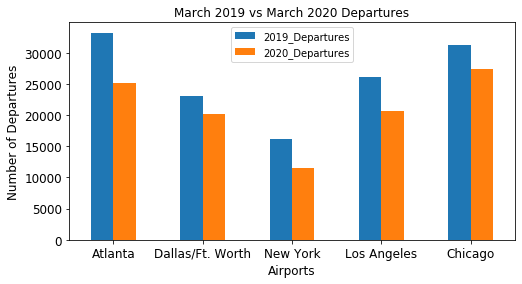

In [16]:
final_march_departure = indexed_march_departures[['2019_Departures','2020_Departures']].plot(kind= 'bar',title = 'March 2019 vs March 2020 Departures', figsize = (8,4),legend = True, fontsize =12, rot=0)
final_march_departure.set_xlabel('Airports', fontsize =12)
final_march_departure.set_ylabel('Number of Departures', fontsize=12)

#Save Bar grpah to file
plt.savefig('marchdepartures.png')

In [ ]:
###Begin Max&Danny&Dave's work on Departure Seats calculation for all 5 years

In [83]:
#display combined_airport df
combined_airport

,Date,Airport,Flight Type,Departures,Departure Seats
0,2016-01-01,ATL - Atlanta,US to Foreign,9,"2,975"
1,2016-01-01,ATL - Atlanta,US to Foreign,1,550
2,2016-01-01,ATL - Atlanta,US to Foreign,1,0
3,2016-01-01,ATL - Atlanta,US to Foreign,7,"1,610"
4,2016-01-01,ATL - Atlanta,US to Foreign,5,"1,225"
...,...,...,...,...,...
37359,2020-07-01,DFW - Dallas/Ft. Worth,Domestic,0,0
37360,2020-07-01,JFK - New York,Domestic,0,0
37361,2020-07-01,JFK - New York,Domestic,0,0
37362,2020-07-01,ORD - Chicago,Domestic,0,0


In [84]:
#Change Date to datetime
combined_airport['month'] = pd.to_datetime(combined_airport['Date'], format='%m/%d/%Y').dt.month
combined_airport['year'] = pd.to_datetime(combined_airport['Date'], format='%m/%d/%Y').dt.year
combined_airport

,Date,Airport,Flight Type,Departures,Departure Seats,month,year
0,2016-01-01,ATL - Atlanta,US to Foreign,9,"2,975",1,2016
1,2016-01-01,ATL - Atlanta,US to Foreign,1,550,1,2016
2,2016-01-01,ATL - Atlanta,US to Foreign,1,0,1,2016
3,2016-01-01,ATL - Atlanta,US to Foreign,7,"1,610",1,2016
4,2016-01-01,ATL - Atlanta,US to Foreign,5,"1,225",1,2016
...,...,...,...,...,...,...,...
37359,2020-07-01,DFW - Dallas/Ft. Worth,Domestic,0,0,7,2020
37360,2020-07-01,JFK - New York,Domestic,0,0,7,2020
37361,2020-07-01,JFK - New York,Domestic,0,0,7,2020
37362,2020-07-01,ORD - Chicago,Domestic,0,0,7,2020


In [85]:
#Change Data Type for Departure Seats in combined_airport to Integer
combined_airport["Departure Seats"] = combined_airport["Departure Seats"].astype(str) 
combined_airport["Departure Seats"] = combined_airport["Departure Seats"].str.replace(',', '')
combined_airport["Departure Seats"] = combined_airport["Departure Seats"].astype(int)
combined_airport.dtypes

Date               datetime64[ns]
Airport                    object
Flight Type                object
Departures                  int64
Departure Seats             int64
month                       int64
year                        int64
dtype: object

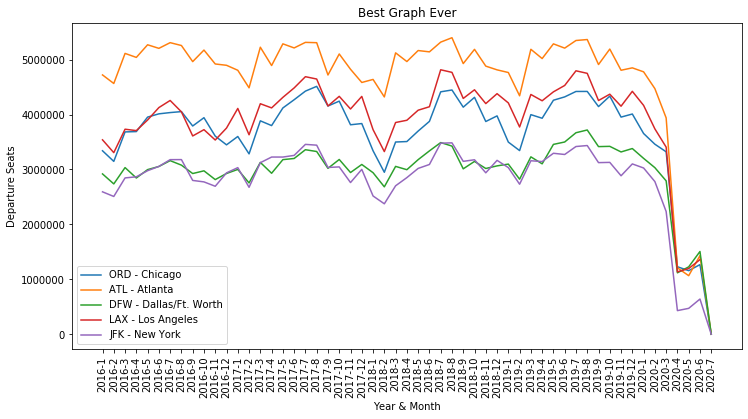

<Figure size 864x432 with 0 Axes>

In [86]:
import matplotlib.pyplot as plt
# Used for combining year-month
date_group = []
# Self explains
airport_names = ["ORD - Chicago",
                 "ATL - Atlanta",
                 "DFW - Dallas/Ft. Worth",
                 "LAX - Los Angeles",
                 "JFK - New York"]
# The group by used to sum departures
gp = combined_airport.groupby(['Airport','year','month'])
airport_all = gp.sum()
#print(airport_all)
# concatenating the multiindex year and month column into one
for i in airport_all.index:
    date_group.append(str(i[1]) + "-" + str(i[2]))
# Creating the x axis values used to display the time series
airport_all["date_group"] = date_group
# Drop the index
airport_all.droplevel(['year', 'month'])
# Conjutes the canvas used to draw the graphs
fig, ax = plt.subplots()
# Iterate over airports and draws a time series for each
for airport in airport_names:
    df = airport_all.loc[airport,["Departure Seats", "date_group"]]
    line, = ax.plot(df["date_group"], df["Departure Seats"], label = airport)
plt.xticks(rotation=90)
plt.xlabel("Year & Month")
plt.ylabel("Departure Seats")
ax.legend()
#plt.rcParams['figure.figsize'] = (16,8)
plt.title("Best Graph Ever")
plt.show()
plt.savefig('../images/departseats_all.png')

In [21]:
########### Dave's code below for 2017-18 flu ################
# import and clean data from CDC FluView website csv download

In [22]:
# define data file
flu_state = "../project_data/flu_data/State_ILINet.csv"

In [23]:
# read data file
raw_state_flu_2017 = pd.read_csv(flu_state)

In [24]:
raw_state_flu_2017.head(15)

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
0,States,Alabama,2017,40,X,1.75721,X,X,X,X,X,X,698,85,39722
1,States,Alaska,2017,40,X,2.72675,X,X,X,X,X,X,141,17,5171
2,States,Arizona,2017,40,X,2.3554,X,X,X,X,X,X,406,42,17237
3,States,Arkansas,2017,40,X,0.812294,X,X,X,X,X,X,37,17,4555
4,States,California,2017,40,X,1.75421,X,X,X,X,X,X,852,102,48569
5,States,Colorado,2017,40,X,0.561578,X,X,X,X,X,X,129,42,22971
6,States,Connecticut,2017,40,X,1.04416,X,X,X,X,X,X,48,17,4597
7,States,Delaware,2017,40,X,0.0717875,X,X,X,X,X,X,2,13,2786
8,States,District of Columbia,2017,40,X,1.91672,X,X,X,X,X,X,284,5,14817
9,States,Florida,2017,40,X,X,X,X,X,X,X,X,X,X,X


In [25]:
# create datetime column from year and week 
raw_state_flu_2017['formatted_date'] = raw_state_flu_2017.YEAR * 1000 + raw_state_flu_2017.WEEK * 10
raw_state_flu_2017['date'] = pd.to_datetime(raw_state_flu_2017['formatted_date'], format='%Y%W%w')
raw_state_flu_2017.head()

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS,formatted_date,date
0,States,Alabama,2017,40,X,1.75721,X,X,X,X,X,X,698,85,39722,2017400,2017-10-08
1,States,Alaska,2017,40,X,2.72675,X,X,X,X,X,X,141,17,5171,2017400,2017-10-08
2,States,Arizona,2017,40,X,2.3554,X,X,X,X,X,X,406,42,17237,2017400,2017-10-08
3,States,Arkansas,2017,40,X,0.812294,X,X,X,X,X,X,37,17,4555,2017400,2017-10-08
4,States,California,2017,40,X,1.75421,X,X,X,X,X,X,852,102,48569,2017400,2017-10-08


In [26]:
# collect a list of all columns within the DataFrame
raw_state_flu_2017.columns

Index(['REGION TYPE', 'REGION', 'YEAR', 'WEEK', '% WEIGHTED ILI',
       '%UNWEIGHTED ILI', 'AGE 0-4', 'AGE 25-49', 'AGE 25-64', 'AGE 5-24',
       'AGE 50-64', 'AGE 65', 'ILITOTAL', 'NUM. OF PROVIDERS',
       'TOTAL PATIENTS', 'formatted_date', 'date'],
      dtype='object')

In [27]:
# extract required columns to new DataFrame
temp_state_flu_2017 = raw_state_flu_2017[['REGION', 'YEAR', 'WEEK', 'date', 'ILITOTAL']]
temp_state_flu_2017.head()

,REGION,YEAR,WEEK,date,ILITOTAL
0,Alabama,2017,40,2017-10-08,698
1,Alaska,2017,40,2017-10-08,141
2,Arizona,2017,40,2017-10-08,406
3,Arkansas,2017,40,2017-10-08,37
4,California,2017,40,2017-10-08,852


In [28]:
# drop rows with "X" in ILITOTAL column
temp_state_flu_2017 = temp_state_flu_2017[temp_state_flu_2017.ILITOTAL != 'X']
temp_state_flu_2017.head(15)

,REGION,YEAR,WEEK,date,ILITOTAL
0,Alabama,2017,40,2017-10-08,698
1,Alaska,2017,40,2017-10-08,141
2,Arizona,2017,40,2017-10-08,406
3,Arkansas,2017,40,2017-10-08,37
4,California,2017,40,2017-10-08,852
5,Colorado,2017,40,2017-10-08,129
6,Connecticut,2017,40,2017-10-08,48
7,Delaware,2017,40,2017-10-08,2
8,District of Columbia,2017,40,2017-10-08,284
10,Georgia,2017,40,2017-10-08,850


In [29]:
#check data types
temp_state_flu_2017.dtypes

REGION              object
YEAR                 int64
WEEK                 int64
date        datetime64[ns]
ILITOTAL            object
dtype: object

In [30]:
# identify incomplete rows
temp_state_flu_2017.count()

REGION      2600
YEAR        2600
WEEK        2600
date        2600
ILITOTAL    2600
dtype: int64

In [31]:
# use pd.to_numeric() method to convert the datatype of the ILITOTAL column
temp_state_flu_2017['ILITOTAL'] = pd.to_numeric(temp_state_flu_2017['ILITOTAL'])
temp_state_flu_2017['ILITOTAL'].dtype

dtype('int64')

In [32]:
# rename the columns     
clean_state_flu_2017 = temp_state_flu_2017.rename(columns={"REGION":"State",
                                                           "YEAR":"Year",
                                                           "WEEK":"Week",
                                                           "date":"Week Ending Date",
                                                           "ILITOTAL":"ILI Cases"})
clean_state_flu_2017.head()

,State,Year,Week,Week Ending Date,ILI Cases
0,Alabama,2017,40,2017-10-08,698
1,Alaska,2017,40,2017-10-08,141
2,Arizona,2017,40,2017-10-08,406
3,Arkansas,2017,40,2017-10-08,37
4,California,2017,40,2017-10-08,852


In [33]:
# determine the total number of ILI Cases
total_cases = clean_state_flu_2017["ILI Cases"].sum()
total_cases

1085870

In [34]:
# determine the total of all ILI Cases by week
ILI_by_week = clean_state_flu_2017.groupby(['Week Ending Date']).sum()['ILI Cases']
ILI_by_week

Week Ending Date
2017-10-08    11343
2017-10-15    11585
2017-10-22    12400
2017-10-29    13721
2017-11-05    14932
2017-11-12    16877
2017-11-19    19061
2017-11-26    17474
2017-12-03    21453
2017-12-10    21936
2017-12-17    28435
2017-12-24    39147
2017-12-31    41383
2018-01-07    43428
2018-01-14    51481
2018-01-21    56161
2018-01-28    68029
2018-02-04    75649
2018-02-11    76307
2018-02-18    66326
2018-02-25    45937
2018-03-04    32349
2018-03-11    25973
2018-03-18    23097
2018-03-25    21085
2018-04-01    18100
2018-04-08    16919
2018-04-15    14649
2018-04-22    13075
2018-04-29    12647
2018-05-06    11330
2018-05-13     9730
2018-05-20     9259
2018-05-27     8730
2018-06-03     8015
2018-06-10     6931
2018-06-17     5931
2018-06-24     5918
2018-07-01     5655
2018-07-08     5122
2018-07-15     5301
2018-07-22     4640
2018-07-29     4534
2018-08-05     4533
2018-08-12     4742
2018-08-19     5424
2018-08-26     6220
2018-09-02     6967
2018-09-09     8272
201

In [35]:
type(ILI_by_week)

pandas.core.series.Series

In [36]:
# count how many ILI cases have occured within each state
ILI_by_state = clean_state_flu_2017.groupby('State').sum()['ILI Cases']
ILI_by_state.head()

State
Alabama       67520
Alaska         9203
Arizona       25945
Arkansas       6302
California    55499
Name: ILI Cases, dtype: int64

In [37]:
type(ILI_by_state)

pandas.core.series.Series

In [38]:
# determine the total of all ILI Cases by week per state
ILI_by_state_by_week = clean_state_flu_2017.groupby(['State', 'Week Ending Date']).sum()['ILI Cases']
ILI_by_state_by_week.head(15)

State    Week Ending Date
Alabama  2017-10-08           698
         2017-10-15           738
         2017-10-22           710
         2017-10-29           799
         2017-11-05           979
         2017-11-12           964
         2017-11-19          1100
         2017-11-26           967
         2017-12-03          1239
         2017-12-10          1274
         2017-12-17          1737
         2017-12-24          3116
         2017-12-31          3583
         2018-01-07          3738
         2018-01-14          4829
Name: ILI Cases, dtype: int64

In [39]:
type(ILI_by_state_by_week)

pandas.core.series.Series

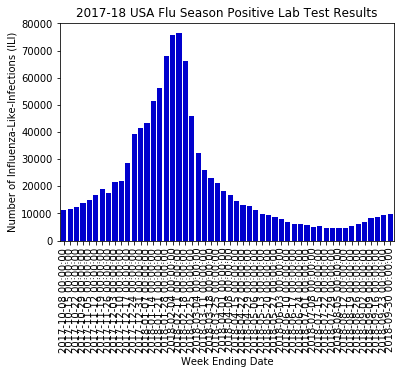

In [40]:
# create a bar chart from the series
ILI_by_week.plot.bar(x='Week Ending Date', y=ILI_by_week, color='mediumblue', align="center", width=0.8)

# Method 1
#fig, ax = plt.subplots()
#loc = WeekdayLocator(byweekday=SU, interval=4, tz=None)
#ax.xaxis.set_major_locator(loc)

# Method 2
def apply_date_formatting_to_axis(ax):
    # format x-axis of input plot to a readable date format
    dates = ['Week Ending Date']
    ax.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=SU, interval=4))
    #ax.xaxis.set_major_formatter(dates.DateFormatter('%d\n%a'))
    #ax.xaxis.grid(True, which="minor")
    #ax.yaxis.grid()
    return ax 

# Method 3
# tell matplotlib which x axis labels to display
# for i, t in enumerate(['Week Ending Date'].get_xlabel()):
#     if (i % 5) != 0:
#         t.set_visible(False)

# give the chart some labels and a title
plt.title("2017-18 USA Flu Season Positive Lab Test Results")
plt.xlabel("Week Ending Date")
plt.ylabel("Number of Influenza-Like-Infections (ILI)")

# change figure size
plt.rcParams['figure.figsize'] = (12,6)

# save an image of the chart and print it to the screen
plt.savefig("../images/flu_by_week.png")
plt.show()

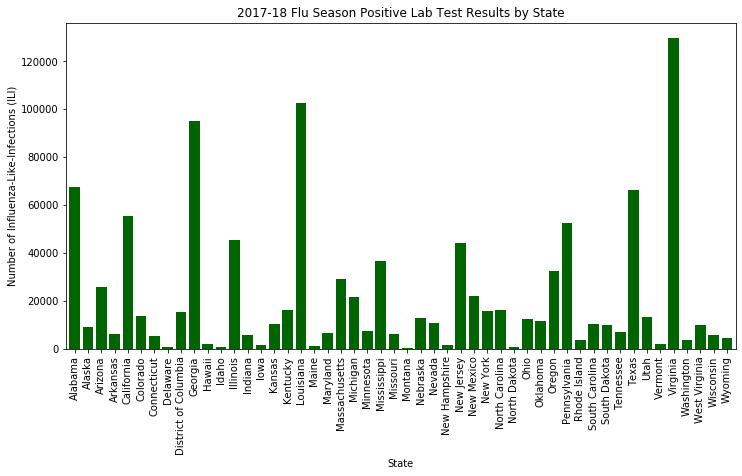

In [41]:
# create a bar chart from the series
ILI_by_state.plot.bar(x='Week Ending Date', y=ILI_by_state, color='darkgreen', align="center", width=0.8)

# give the chart some labels and a title
plt.title("2017-18 Flu Season Positive Lab Test Results by State")
plt.xlabel("State")
plt.ylabel("Number of Influenza-Like-Infections (ILI)")

# change figure size
plt.rcParams['figure.figsize'] = (12,6)

# save an image of the chart and print it to the screen
plt.savefig("../images/flu_by_state.png")
plt.show()

In [61]:
#### Part three: Build correlation graphs

#display df
combined_airport

,Date,Airport,Flight Type,Departures,Departure Seats
0,2016-01-01,ATL - Atlanta,US to Foreign,9,"2,975"
1,2016-01-01,ATL - Atlanta,US to Foreign,1,550
2,2016-01-01,ATL - Atlanta,US to Foreign,1,0
3,2016-01-01,ATL - Atlanta,US to Foreign,7,"1,610"
4,2016-01-01,ATL - Atlanta,US to Foreign,5,"1,225"
...,...,...,...,...,...
37359,2020-07-01,DFW - Dallas/Ft. Worth,Domestic,0,0
37360,2020-07-01,JFK - New York,Domestic,0,0
37361,2020-07-01,JFK - New York,Domestic,0,0
37362,2020-07-01,ORD - Chicago,Domestic,0,0


In [62]:
#build df with jan to june
start_2018 = '01-01-2018'
end_2018 = '06-30-2018'

#mask date column
mask = (combined_airport["Date"] >= start_2018) & (combined_airport["Date"] <= end_2018)

flu_dates = pd.DataFrame()
flu_dates = combined_airport.loc[mask]
flu_dates

,Date,Airport,Flight Type,Departures,Departure Seats
0,2018-01-01,ATL - Atlanta,US to Foreign,5,"1,675"
1,2018-01-01,ATL - Atlanta,US to Foreign,1,335
2,2018-01-01,ATL - Atlanta,US to Foreign,6,"1,380"
3,2018-01-01,ATL - Atlanta,US to Foreign,6,"1,470"
4,2018-01-01,ATL - Atlanta,US to Foreign,6,"1,775"
...,...,...,...,...,...
45162,2018-06-30,ORD - Chicago,Domestic,1,90
45163,2018-06-30,ORD - Chicago,Domestic,74,"3,700"
45164,2018-06-30,ORD - Chicago,Domestic,55,"3,850"
45165,2018-06-30,ORD - Chicago,Domestic,5,450


In [70]:
#extract date and departures into new df, then pull covid data into this dataframe.
airline_week_total = combined_airport[["Date", "Airport", "Flight Type", "Departures"]]
airline_week_total

#grouping by date
airline_week_total.groupby(["Date"])

In [71]:
airline_week_total["Air Week"] = airline_week_total["Date"].dt.week
airline_week_total

,Date,Airport,Flight Type,Departures,Air Week
0,2016-01-01,ATL - Atlanta,US to Foreign,9,53
1,2016-01-01,ATL - Atlanta,US to Foreign,1,53
2,2016-01-01,ATL - Atlanta,US to Foreign,1,53
3,2016-01-01,ATL - Atlanta,US to Foreign,7,53
4,2016-01-01,ATL - Atlanta,US to Foreign,5,53
...,...,...,...,...,...
37359,2020-07-01,DFW - Dallas/Ft. Worth,Domestic,0,27
37360,2020-07-01,JFK - New York,Domestic,0,27
37361,2020-07-01,JFK - New York,Domestic,0,27
37362,2020-07-01,ORD - Chicago,Domestic,0,27


In [72]:
#flu main df's data types:
clean_state_flu_2017.dtypes

State                       object
Year                         int64
Week                         int64
Week Ending Date    datetime64[ns]
ILI Cases                    int64
dtype: object

In [73]:
#new df with mask for flu data 
wkstart = 1
wkend = 26
mask_flu = (clean_state_flu_2017["Week"] >= wkstart) & (clean_state_flu_2017["Week"] <= wkend)

flu_wk = pd.DataFrame()
flu_wk = clean_state_flu_2017.loc[mask_flu]
flu_wk

,State,Year,Week,Week Ending Date,ILI Cases
663,Alabama,2018,1,2018-01-07,3738
664,Alaska,2018,1,2018-01-07,222
665,Arizona,2018,1,2018-01-07,1249
666,Arkansas,2018,1,2018-01-07,257
667,California,2018,1,2018-01-07,2310
...,...,...,...,...,...
1984,Virginia,2018,26,2018-07-01,767
1985,Washington,2018,26,2018-07-01,19
1986,West Virginia,2018,26,2018-07-01,6
1987,Wisconsin,2018,26,2018-07-01,1


In [75]:
#new df with mask for airline data 
wkstart = 1
wkend = 26
mask_air = (airline_week_total["Air Week"] >= wkstart) & (airline_week_total["Air Week"] <= wkend)

air_wk = pd.DataFrame()
air_wk = airline_week_total.loc[mask_air]
air_wk

,Date,Airport,Flight Type,Departures,Air Week
716,2016-01-04,ATL - Atlanta,US to Foreign,1,1
717,2016-01-04,ATL - Atlanta,US to Foreign,8,1
718,2016-01-04,ATL - Atlanta,US to Foreign,1,1
719,2016-01-04,ATL - Atlanta,US to Foreign,1,1
720,2016-01-04,ATL - Atlanta,US to Foreign,1,1
...,...,...,...,...,...
37016,2020-06-28,ORD - Chicago,Domestic,16,26
37017,2020-06-28,ORD - Chicago,Domestic,46,26
37018,2020-06-28,ORD - Chicago,Domestic,46,26
37019,2020-06-28,ORD - Chicago,Domestic,44,26


In [76]:
#create new df with flu by week & departures by week
flu_final = flu_wk.groupby("Week").sum()["ILI Cases"]
air_final = air_wk.groupby("Air Week").sum()["Departures"]

# Create a DataFrame to hold results
flu_vs_air = pd.DataFrame({"Departures": air_final, 
                           "Flu Cases": flu_final
                          })


flu_vs_air

,Departures,Flu Cases
1,145934,43428
2,144186,51481
3,140686,56161
4,144448,68029
5,140858,75649
6,142126,76307
7,144795,66326
8,148292,45937
9,149635,32349
10,152258,25973


The correlation between flight departures and flu cases is 0.44


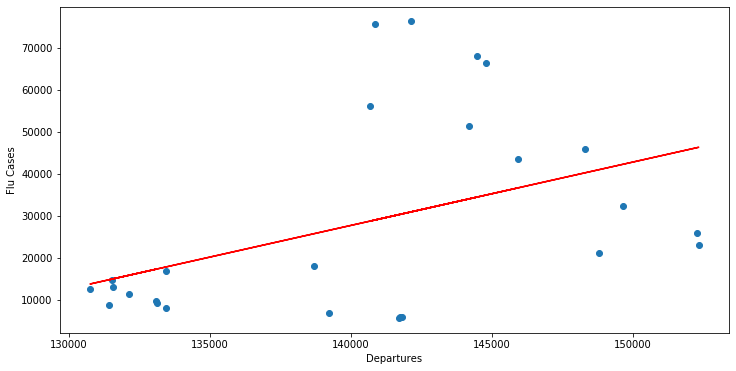

<Figure size 864x432 with 0 Axes>

In [82]:
# Calculate the correlation coefficient and linear regression model 
# for flu vs air

corr=round(st.pearsonr(flu_vs_air["Departures"],flu_vs_air["Flu Cases"])[0],2)
print(f"The correlation between flight departures and flu cases is {corr}")
model = st.linregress(flu_vs_air["Departures"],flu_vs_air["Flu Cases"])

y_values = flu_vs_air["Departures"]*model[0]+model[1]
plt.scatter(flu_vs_air["Departures"],flu_vs_air["Flu Cases"])
plt.plot(flu_vs_air["Departures"],y_values,color="red")
plt.xlabel("Departures")
plt.ylabel("Flu Cases")
plt.show()
plt.savefig("../images/flucorr.png")